In [1]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import pandas as pd
from statsmodels.graphics.api import qqplot

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import multivariate_normal


In [42]:

# Data Visualiztion
def plot_kalman(x,y,nx,ny,kx=None,ky=None, plot_type="r-", label=None, title='Parabola'):
    """
    Plot the trajectory
    """
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    if kx is not None and ky is not None:
        ax[0].plot(x,y,'g-',nx,ny,'b.',kx,ky, plot_type)
        ax[0].plot(kx[0], ky[0], 'or')
        ax[0].plot(kx[-1], ky[-1], 'xr')
        
        ax[1].plot(x, kx, '.k', label='latent dim 1')
        ax[1].plot(y, ky, '.', color='grey', label='latent dim 2')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        ax[1].legend()
    else:
        ax[0].plot(x,y,'g-',nx,ny,'b.')
        
        ax[1].plot(x, nx, '.k', label='dim 1')
        ax[1].plot(y, ny, '.', color='grey', label='dim 2')
        ax[1].set_xlabel('latent')
        ax[1].set_ylabel('observed')
        ax[1].legend()

    ax[0].set_xlabel('X position')
    ax[0].set_ylabel('Y position')
    ax[0].set_title(title)
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    
    if kx is not None and ky is not None and label is not None:
        ax[0].legend(('true','measured', label))
    else:
        ax[0].legend(('true','measured'))
    
    return fig
    
def visualize_line_plot(data, xlabel, ylabel, title):
    """
    Function that visualizes a line plot
    """
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def print_parameters(kf_model, need_params=None, evals=False):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if evals:
        if need_params is None:
            need_params1 = ['transition_matrices', 'transition_covariance', 'observation_covariance', 'initial_state_covariance']
            need_params2 = ['observation_matrices', 'initial_state_mean']
        for param in need_params1: 
            tmp = np.linalg.eig(getattr(kf_model, param))[0]
            print("{0} = {1}, shape = {2}\n".format(param, tmp, tmp.shape))
        for param in need_params2: 
            print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
    else:
        if need_params is None:
            need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 'observation_covariance', 
                            'initial_state_mean', 'initial_state_covariance']
        for param in need_params: 
            print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))
    

In [4]:
readcsv_GenMix_2018_2022=pd.read_csv(r"..\ImportData\GenMix_2018_2022.csv")

(array([1.31453e+05, 1.48392e+05, 7.45850e+04, 2.66270e+04, 9.54000e+03,
        3.84800e+03, 1.66500e+03, 8.60000e+02, 3.84000e+02, 3.20000e+01]),
 array([  57.7 ,  469.13,  880.56, 1291.99, 1703.42, 2114.85, 2526.28,
        2937.71, 3349.14, 3760.57, 4172.  ]),
 <BarContainer object of 10 artists>)

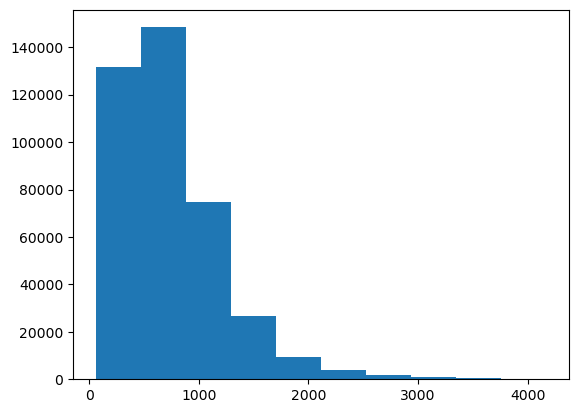

In [9]:
plt.hist(readcsv_GenMix_2018_2022[' Natural Gas Market']+readcsv_GenMix_2018_2022[' Natural Gas Self'])

In [58]:
readcsv_GenMix_2018_2022

GMT MKT Interval   Coal Market   Coal Self  \
0       2018-01-01T06:00:00Z        2948.5     18203.9   
1       2018-01-01T06:05:00Z        2917.3     18191.4   
2       2018-01-01T06:10:00Z        2916.5     18181.4   
3       2018-01-01T06:15:00Z        2913.0     18159.0   
4       2018-01-01T06:20:00Z        2911.5     18154.1   
...                      ...           ...         ...   
398535  2022-10-16T21:40:00Z           NaN         NaN   
398536  2022-10-16T21:45:00Z           NaN         NaN   
398537  2022-10-16T21:50:00Z           NaN         NaN   
398538  2022-10-16T21:55:00Z           NaN         NaN   
398539  2022-10-16T22:00:00Z           NaN         NaN   

         Diesel Fuel Oil Market   Diesel Fuel Oil Self   Hydro Market  \
0                           0.0                    4.4           43.1   
1                           0.0                    4.4           43.3   
2                           0.0                    0.0           43.8   
3                           0.0                    0.0           43.8   
4                           0.0                    0.0           43.3   
...                         ...                    ...            ...   
398535                      NaN                    NaN            NaN   
398536                      NaN                    NaN            NaN   
398537                      NaN                    NaN            NaN   
398538                      NaN                    NaN            NaN   
398539                      NaN                    NaN            NaN   

         Hydro Self   Natural Gas Market   Natural Gas Self   Nuclear Market  \
0             759.6               5903.9             3447.6              0.0   
1             775.3               5842.2             3468.0              0.0   
2             802.2               5983.2             3479.6              0.0   
3             776.5               6116.0             3385.1              0.0   
4             713.7               6182.6             3438.3              0.0   
...             ...                  ...                ...              ...   
398535          NaN                  NaN                NaN              NaN   
398536          NaN                  NaN                NaN              NaN   
398537          NaN                  NaN                NaN              NaN   
398538          NaN                  NaN                NaN              NaN   
398539          NaN                  NaN                NaN              NaN   

        ...   Solar Self   Waste Disposal Services Market  \
0       ...          0.0                              0.0   
1       ...          0.0                              0.0   
2       ...          0.0                              0.0   
3       ...          0.0                              0.0   
4       ...          0.0                              0.0   
...     ...          ...                              ...   
398535  ...          NaN                              NaN   
398536  ...          NaN                              NaN   
398537  ...          NaN                              NaN   
398538  ...          NaN                              NaN   
398539  ...          NaN                              NaN   

         Waste Disposal Services Self   Wind Market   Wind Self  \
0                                10.8           0.0      3643.1   
1                                10.9           0.0      3619.8   
2                                11.0           0.0      3578.9   
3                                10.9           0.0      3539.2   
4                                10.9           0.0      3515.1   
...                               ...           ...         ...   
398535                            NaN           NaN         NaN   
398536                            NaN           NaN         NaN   
398537                            NaN           NaN         NaN   
398538                            NaN           NaN         NaN   
398539 

In [18]:
readcsv_GenMix_2018_2022.columns

Index(['GMT MKT Interval', ' Coal Market', ' Coal Self',
       ' Diesel Fuel Oil Market', ' Diesel Fuel Oil Self', ' Hydro Market',
       ' Hydro Self', ' Natural Gas Market', ' Natural Gas Self',
       ' Nuclear Market', ' Nuclear Self', ' Solar Market', ' Solar Self',
       ' Waste Disposal Services Market', ' Waste Disposal Services Self',
       ' Wind Market', ' Wind Self', ' Waste Heat Market', ' Waste Heat Self',
       ' Other Market', ' Other Self', ' Load'],
      dtype='object')

In [4]:
readcsv_GenMix_2018_2022[' Coal Market']

0         2948.5
1         2917.3
2         2916.5
3         2913.0
4         2911.5
           ...  
398535       NaN
398536       NaN
398537       NaN
398538       NaN
398539       NaN
Name:  Coal Market, Length: 398540, dtype: float64

In [5]:
# From Lab 3
def plot_ccf(x, y, ax=None, lags=None, alpha=.05, use_vlines=True, unbiased=False,
             fft=False, title='Cross-correlation', zero=True, **kwargs):
    fig, ax = utils.create_mpl_ax(ax)
    lags, nlags, irregular = statsmodels.graphics.tsaplots._prepare_data_corr_plot(x, lags, zero)
    confint = None
    ccf_val = ccf(x, y)
    if lags is not None:
        ccf_val = ccf_val[:nlags+1]
    statsmodels.graphics.tsaplots._plot_corr(ax, title, ccf_val, confint, lags, irregular, use_vlines, vlines_kwargs=kwargs)
    # Depending on your version of statsmodels, you may have to use the following instead:
    #statsmodels.graphics.tsaplots._plot_corr(ax, title, ccf_val, confint, lags, irregular, use_vlines, **kwargs)
    return fig

In [7]:
dta=readcsv_GenMix_2018_2022[' Coal Market']

In [16]:
dta = dta.dropna()

In [22]:
dta.shape
int(397386/4)
dta = dta[:99346]

In [23]:
# From Lab 4
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)
plt.show()

C:\Users\chen5\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


In [24]:
# TODO: chose p appropriately
p = 1

arma_mod = sm.tsa.ARIMA(dta, order=(p,0,0)).fit()
print(arma_mod.params)


const     2880.204350
ar.L1        0.999451
sigma2    1511.966477
dtype: float64


In [28]:
dta

0        2948.5
1        2917.3
2        2916.5
3        2913.0
4        2911.5
          ...  
99341    2531.7
99342    2492.1
99343    2487.5
99344    2415.1
99345    2355.8
Name:  Coal Market, Length: 99346, dtype: float64

In [40]:
tsteps= 1000

fig, ax = plt.subplots(figsize=(12, 8))
ax = dta.loc['0':].plot(ax=ax)
T = np.arange(0, 99346, tsteps)
for tt in range(len(T)-1):
    pred = arma_mod.predict(int(T[tt]), int(T[tt+1]))#, ax=ax, plot_insample=False)
    pred.plot(ax=ax)
plt.show()


In [43]:
# Data Visualiztion
def plot_kalman(x,y,nx,ny,kx=None,ky=None, plot_type="r-", label=None):
    """
    Plot the trajectory
    """
    fig = plt.figure()
    if kx is not None and ky is not None:
        plt.plot(x,y,'g-',nx,ny,'b.',kx,ky, plot_type)
        plt.plot(kx[0], ky[0], 'or')
        plt.plot(kx[-1], ky[-1], 'xr')
    else:
        plt.plot(x,y,'g-',nx,ny,'b.')

    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.title('Parabola')
    
    if kx is not None and ky is not None and label is not None:
        plt.legend(('true','measured', label))
    else:
        plt.legend(('true','measured'))
    
    return fig
    
def visualize_line_plot(data, xlabel, ylabel, title):
    """
    Function that visualizes a line plot
    """
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def print_parameters(kf_model, need_params=None):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if need_params is None:
        need_params = ['transition_matrices', 'observation_matrices', 'transition_offsets', 
                  'observation_offsets', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    for param in need_params: 
        print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))

In [61]:
data = readcsv_GenMix_2018_2022[readcsv_GenMix_2018_2022.columns[1:3]]

In [62]:
int(398540/4)

99635

In [63]:
data = data[:100]

In [65]:
data

Coal Market   Coal Self
0         2948.5     18203.9
1         2917.3     18191.4
2         2916.5     18181.4
3         2913.0     18159.0
4         2911.5     18154.1
..           ...         ...
95        2807.7     18277.8
96        2796.4     18282.7
97        2788.6     18298.9
98        2782.1     18288.9
99        2779.5     18266.4

[100 rows x 2 columns]

In [66]:
kf = KalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])


In [67]:
kf.em(data, n_iter=6)


In [69]:
filtered_state_means, filtered_state_covariances = kf.filter(data)


In [70]:
filtered_state_means

array([[ 1814.75157858, 11246.11317181],
       [ 2159.34444708, 13523.39576059],
       [ 2480.59226473, 15504.96435103],
       [ 2680.04730751, 16729.16080081],
       [ 2789.5001193 , 17404.92327423],
       [ 2845.78287664, 17866.78701571],
       [ 2870.41378815, 18028.55490595],
       [ 2884.33073032, 18157.72510098],
       [ 2883.86562727, 18149.83783447],
       [ 2883.95083525, 18151.69319861],
       [ 2885.83241946, 18114.4315056 ],
       [ 2892.08932367, 18115.73957728],
       [ 2895.61446995, 18133.62993675],
       [ 2904.36320371, 17994.6513284 ],
       [ 2921.15471346, 17839.07540118],
       [ 2946.73531782, 17877.06344793],
       [ 2968.3174016 , 18014.7426165 ],
       [ 2982.63854957, 18080.50141716],
       [ 2994.31107387, 18188.59039376],
       [ 3000.27457198, 18244.8813362 ],
       [ 3001.00538326, 18189.5600258 ],
       [ 3004.53407858, 18194.78838845],
       [ 3006.33466348, 18166.36446815],
       [ 3012.79843022, 18245.76160955],
       [ 3012.31

In [78]:
data.columns

Index([' Coal Market', ' Coal Self'], dtype='object')

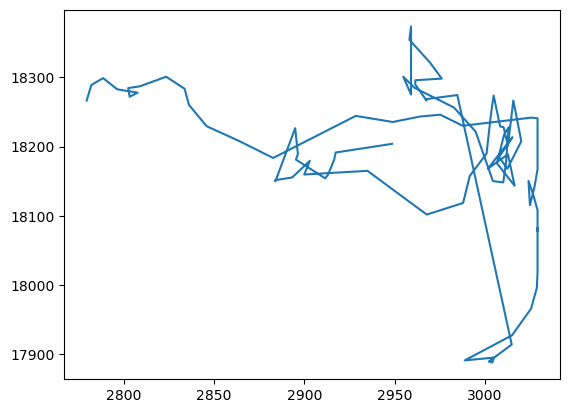

In [79]:
plt.plot(data[data.columns[0]],data[data.columns[1]])

In [73]:
plt.plot(filtered_state_means[:,0],filtered_state_means[:,1])

In [71]:
filtered_state_covariances

array([[[3.48707723e-01, 5.39816070e-03],
        [5.39816070e-03, 3.81087703e-01]],

       [[7.67919097e+03, 4.72134839e+04],
        [4.72134839e+04, 2.91019754e+05]],

       [[1.07652598e+04, 6.61562750e+04],
        [6.61562750e+04, 4.07298946e+05]],

       [[1.17236321e+04, 7.20386923e+04],
        [7.20386923e+04, 4.43404817e+05]],

       [[1.19962369e+04, 7.37119165e+04],
        [7.37119165e+04, 4.53674921e+05]],

       [[1.20718051e+04, 7.41757473e+04],
        [7.41757473e+04, 4.56521873e+05]],

       [[1.20926026e+04, 7.43034008e+04],
        [7.43034008e+04, 4.57305399e+05]],

       [[1.20983151e+04, 7.43384632e+04],
        [7.43384632e+04, 4.57520610e+05]],

       [[1.20998832e+04, 7.43480885e+04],
        [7.43480885e+04, 4.57579689e+05]],

       [[1.21003137e+04, 7.43507304e+04],
        [7.43507304e+04, 4.57595905e+05]],

       [[1.21004318e+04, 7.43514556e+04],
        [7.43514556e+04, 4.57600355e+05]],

       [[1.21004642e+04, 7.43516546e+04],
        [7.4

In [55]:
kf = KalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
#kf = KalmanFilter(n_dim_state=4, n_dim_obs=data.shape[1])
# changing latent dimensions does not affect model, doesn't model the velocity

# fit the model (use EM algorithm to estimate the parameters, we will not worry about this for now)
kf.em(data, n_iter=6)
# Kalman filtering
filtered_state_means, filtered_state_covariances = kf.filter(data)
fig = plot_kalman(x,y,nx,ny, filtered_state_means[:,0], filtered_state_means[:,1], "r-", "kf-filter")


KeyboardInterrupt: 

In [38]:
# Sampling
n_dim_state = 2
n_dim_obs = 2
kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
# set paramters
kf.transition_matrices = np.eye(kf.n_dim_state)*.5
kf.transition_covariance = np.eye(kf.n_dim_obs)
kf.observation_matrices = np.eye(kf.n_dim_state)
kf.observation_covariance = np.eye(kf.n_dim_obs)*.1
kf.initial_state_mean = np.zeros(kf.n_dim_state)
kf.initial_state_covariance = np.eye(kf.n_dim_state)*.1
# import to your own kalman object


In [ ]:
np.random.seed(0)

iters = 10
# perturb starting parameters
kf = KalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1],
                 transition_matrices= np.eye(data.shape[1]) * 0.95,
                 observation_matrices= np.eye(data.shape[1])+np.random.randn(data.shape[1])*.1,
                 transition_covariance= np.eye(data.shape[1]),
                 observation_covariance = np.eye(data.shape[1]),
                 initial_state_mean=np.random.randn(data.shape[1]),
                  initial_state_covariance = np.eye(data.shape[1]),
                 em_vars = ['transition_matrices', 'observation_matrices','transition_covariance','observation_covariance',
                          'initial_state_mean', 'initial_state_covariance'])

my_kf = MyKalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
my_kf.import_param(kf)

kf.em(data, n_iter=iters)
my_kf.em(data, max_iter=iters)

print('           pykalman EM:')
print(' ')
print_parameters(kf, evals=True)